In [12]:
import sys
sys.path.append("../../..")

from heritageconnector import datastore
from heritageconnector.config import field_mapping
from heritageconnector.best_spacy_pipeline import load_model
from heritageconnector.datastore import es, index
from smg_jobs.smg_loader import preprocess_text_for_ner

import matplotlib.pyplot as plt

import pandas as pd
pd.options.display.max_rows = None
pd.options.display.max_colwidth = None

### NERLoader

In [2]:
source_description_field = target_description_field = "data.http://www.w3.org/2001/XMLSchema#description"
target_title_field = "graph.@rdfs:label.@value"
target_alias_field = "graph.@skos:altLabel.@value"
target_type_field = "graph.@skos:hasTopConcept.@value"

record_loader = datastore.RecordLoader("SMG", field_mapping)
ner_loader = datastore.NERLoader(
    record_loader,
    source_es_index = 'heritageconnector_test',
    target_es_index = 'heritageconnector_test',
    source_description_field = source_description_field, 
    target_title_field = target_title_field, 
    target_description_field = target_description_field, 
    target_type_field = target_type_field,
    target_alias_field = target_alias_field,
    entity_types_to_link={"PERSON", "OBJECT", "ORG"},
    text_preprocess_func=preprocess_text_for_ner
)

In [20]:
ner_loader._get_ner_model("en_core_web_trf").pipe_names

spacy tried to use GPU but failed
2021-03-30 12:13:33,532 - hc_nlp.pipeline - INFO - Loading thesaurus from ../../../heritageconnector/../GITIGNORE_DATA/labels_all_unambiguous_types_people_orgs.jsonl
2021-03-30 12:13:34,894 - hc_nlp.pipeline - INFO - 17016 term thesaurus imported in 1s


['transformer',
 'tagger',
 'parser',
 'pattern_matcher',
 'date_matcher',
 'ner',
 'thesaurus_matcher',
 'attribute_ruler',
 'lemmatizer',
 'entity_filter',
 'map_entity_types',
 'entity_joiner',
 'duplicate_entity_detector']

In [3]:
from tqdm.auto import tqdm
from itertools import islice

num_docs = 150000
doc_generator = islice(ner_loader._get_doc_generator('heritageconnector_test'), num_docs)
all_docs = []

for item in tqdm(doc_generator, total=num_docs):
    all_docs.append(item)

  0%|          | 0/150000 [00:00<?, ?it/s]

In [4]:
df = pd.DataFrame(all_docs, columns=['uri', 'description'])
df['len'] = df['description'].apply(len)
df['len_words'] = df['description'].apply(lambda x: len(x.split(" ")))

In [5]:
df.head()

,uri,description,len,len_words
0,https://collection.sciencemuseumgroup.org.uk/objects/co8409961,"Ferranti HB876 area denial mine, made in Moston c1985. This is a Hunting Percival JP233 sub-munition used to hamprer the repair of bomb craters on runways",154,26
1,https://collection.sciencemuseumgroup.org.uk/objects/co21567,Result of heating sulphate of lead with lead,44,8
2,https://collection.sciencemuseumgroup.org.uk/objects/co194608,"1 bottle of Petrolagar emulsion with phenolphthalein, (liquid paraffin), by Petrolagar, physician's sample, 1960-1980",117,14
3,https://collection.sciencemuseumgroup.org.uk/objects/co84661,"Votive left leg on inscribed plaque, 20th century copy by Brucciani, original from shrine of Asklepios on Melos, Greek, 400-100 BC. Made in London E.C. 1900-1930",162,27
4,https://collection.sciencemuseumgroup.org.uk/objects/co8100418,"Isle of Wight Central Railway handbill 'royal marine artillery band at Ryde'. Printed by W.H. Upward. Issued by Russell Willmott, general manager. Dated March 1915.",165,26


Text(0.5, 0, 'document idx')

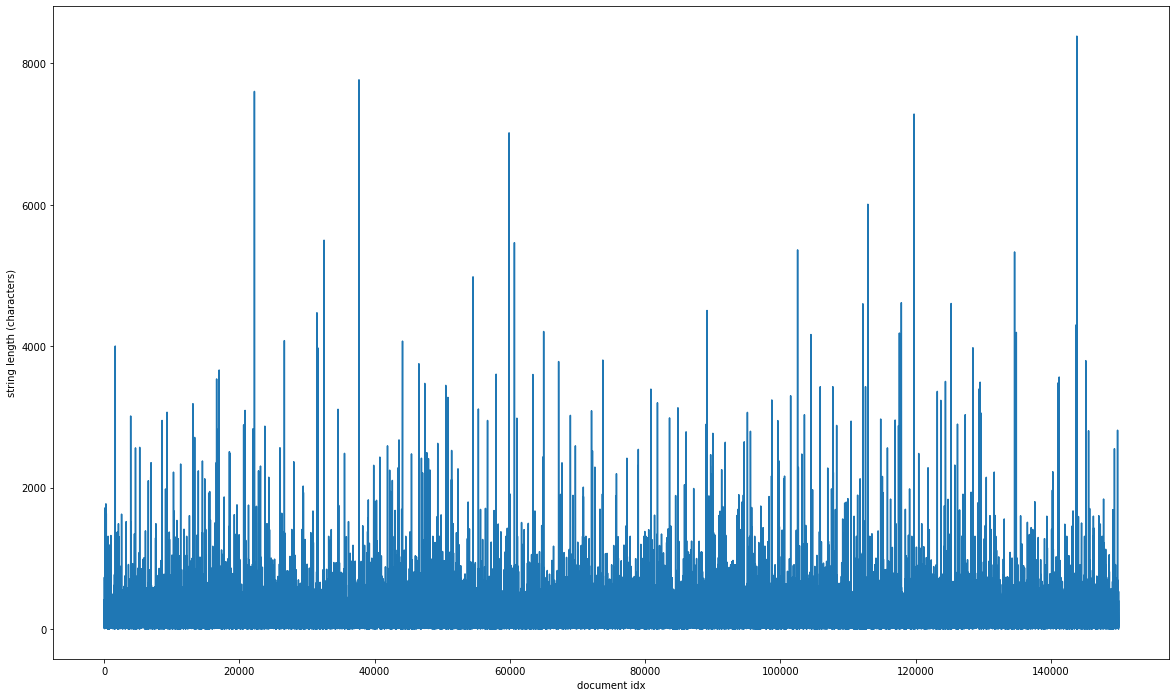

In [17]:
_, ax = plt.subplots(figsize=(20,12))
df.len.plot(kind='line', ax=ax)
ax.set_ylabel("string length (characters)")
ax.set_xlabel("document idx")